In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import h5py
import quimb as qu
from pathlib import Path
from matplotlib.colors import LogNorm

from itertools import product
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import MultiStepLR
from mpl_toolkits.axes_grid1 import make_axes_locatable

from models import Lindbladian
from ml.classes import MLLP, CustomDatasetFromHDF5
from utils import print_comparison, create_basis, experimental_data
from ml.sfw.optimizers import Adam
from ml.core import train
from ml.utils import calculate_error

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Benchmark of the Lindblad Dynamycs Approximator

In this notebook we outline how we benchmarked the ML algorithm.

In [8]:
def initial_conditions(F_base):
    '''Function returning a random density matrix. '''
    rho = qu.gen.rand.rand_rho(4)

    v_0 = np.array([np.trace(np.dot(rho,f)) for f in F_base]).real
    return v_0[1:]

## Create the data
First we create the data. 
This section can be skipped and use directly the data in ./data/benchmark.hdf5


The Lindbladian is 
$$H = \frac{\Omega}{2} (\sigma_1^x + \sigma_2^x ) + V n_1 n_2 \, , $$
$$J_1 = \sqrt{\gamma} \sigma_1^- \, , \qquad J_2 = \sqrt{\gamma} \sigma_2^- \, , $$
$$J_3 = \sqrt{\kappa} n_1 \, , \qquad J_4 = \sqrt{\kappa} n_2\, . $$

NOTE: you need to run the following 2 cells also if you do not want to generate some new data.

In [9]:
class LindbladClass(Lindbladian):
    """Subclass implementing the Lindbladian used to generate the data
    """
    def __init__(self, V, gamma, kappa):
        super(LindbladClass, self).__init__()
        self.V = V 
        self.gamma = gamma
        self.kappa = kappa
    
    def kossakowski(self, t):
        s_1 = torch.zeros((15), dtype=torch.cfloat)
        s_2 = torch.zeros((15), dtype=torch.cfloat)
        s_3 = torch.zeros((15), dtype=torch.cfloat)
        s_4 = torch.zeros((15), dtype=torch.cfloat)

        # J1
        s_1[3] = 2
        s_1[7] = 1j*2
        
        # J2
        s_2[0] = 2
        s_2[1] = 1j*2
        
        # J3
        s_3[11] = 1
        
        # J4
        s_4[2] = 1
        
        koss = torch.einsum('i,j->ij', s_1, s_1.conj())*self.gamma
        koss += torch.einsum('i,j->ij', s_2, s_2.conj())*self.gamma
        koss += torch.einsum('i,j->ij', s_3, s_3.conj())*self.kappa
        koss += torch.einsum('i,j->ij', s_4, s_4.conj())*self.kappa
        return koss

    def omega(self, t):
        w = torch.zeros((15))
        w[0] = 1
        w[3] = 1
        w[2] = self.V/2
        w[11] = self.V/2
        w[14] = self.V/2
        
        return w

In [10]:
# set some parameters
prms = {'model': 1,      # label of the model
        'V': 0.5,        # magnitude of the interaction
        'gamma' : 0.01,  # dephasing
        'kappa' : 0.05,  # decay
        'T': 10,         # time window of the evolution
        'T_test':20,     # time window to test the model
        'num_traj': 30,  # number of trajectories for each combination of params
        'N' : 60,        # number of samples for each point in time
        'M' : 60         # number of times for each trajectory
       }

L1 = LindbladClass(prms['V'],prms['gamma'],prms['kappa'])
# base
F = create_basis('zz')

## Data Generation

In [11]:
### CREATE - training set
exp_data = {'X' : [],
            'y' : [],
            't' : []}

for n in range(prms['num_traj']):
    # first I create the exact dynamics
    v_0 = initial_conditions(F)
    results, t = L1.generate_trajectory(v_0=v_0, T=prms['T'])
    
    # select some random times at which to sample
    indeces = np.random.choice(range(1, len(results)), prms['M'], replace=False)
    for i in indeces:
        # same initial conditions and time
        exp_data['X'].append(v_0)
        exp_data['t'].append(t[i])
        # the data
        exp_data['y'].append( experimental_data(results[i], N=prms['N']))
        
### SAVE
gname = 'cohVec_model_' + str(prms['model']) + \
        '_V_' + str(int(prms['V']*1e3)).zfill(4) + \
        '_N_' + str(int(prms['N'])) + '_M_' + str(int(prms['M']))

with h5py.File('./data/benchmark.hdf5', 'a') as f:
    # create the subgroup
    try:
        subg = f.create_group(gname)
    except:
        subg = f[gname]
        del f[gname+'/X']
        del f[gname+'/y']
        del f[gname+'/t']

    subg.create_dataset('X', data=exp_data['X'])
    subg.create_dataset('y', data=exp_data['y'])
    subg.create_dataset('t', data=exp_data['t'])

In [12]:
### CREATE - test set = 10 different trajectories
exp_data = {'y' : [],
            't' : []}

for i in range(10):
    v_0 = initial_conditions(F)
    results, t = L1.generate_trajectory(v_0=v_0, T=prms['T_test'])
    
    exp_data['y'].append( results )
    exp_data['t'].append( t )
        
### SAVE
gname = 'cohVec_model_' + str(prms['model'])

with h5py.File('./data/benchmark_test.hdf5', 'a') as f:
    # create the subgroup
    try:
        subg = f.create_group(gname)
    except:
        subg = f[gname]
        del f[gname+'/y']
        del f[gname+'/t']

    subg.create_dataset('y', data=exp_data['y'])
    subg.create_dataset('t', data=exp_data['t'])

## Train the model

Here I train the ML model

In [13]:
def load_data(path, model, potential, N, M,
              num_traj, batch_size, validation_split):
    '''Function to load the data from hdf5 file.
    Reshuffling of data is performed. Then separates train
    from validation and return the iterables.

    Parameters
    ----------
    path : str
        Path to the hdf5 file
    model : int
        Label fo the model
    potential : float
    N : int
    M : int
    num_traj : int
        All characteristics of the generated data
    batch_size : int
    validation_split : float
        Number 0 < .. < 1 which indicates the relative
        sizes of validation and train

    Return
    ------
    train and validation loaders
    '''
    # group name
    gname = 'cohVec_model_' + str(model) + \
            '_V_' + str(int(potential*1e3)).zfill(4) + \
            '_N_' + str(int(N)) + '_M_' + str(int(M))

    dataset = CustomDatasetFromHDF5(path, gname)

    # creating the indeces for training and validation split
    dataset_size = len(dataset)
    indeces = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    print(f"Data points used in the training {dataset_size}")

    # shuffling the datesets
    np.random.seed(42)
    np.random.shuffle(indeces)
    train_indices, val_indices = indeces[split:], indeces[:split]

    # Creating PT data samplers and loaders
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset,
                                               batch_size=batch_size,
                                               sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             sampler=valid_sampler)
    return train_loader, val_loader

Data points used in the training 1800
= Starting epoch  1 / 400
=== Mean train loss: 0.011578996899
=== lr: 0.01000
= Starting epoch  2 / 400
=== Mean train loss: 0.011533810990
=== lr: 0.01000
= Starting epoch  3 / 400
=== Mean train loss: 0.011166535085
=== lr: 0.01000
= Starting epoch  4 / 400
=== Mean train loss: 0.011327395798
=== lr: 0.01000
= Starting epoch  5 / 400
=== Mean train loss: 0.011268158793
=== lr: 0.01000
= Starting epoch  6 / 400
=== Mean train loss: 0.011337498785
=== lr: 0.01000
= Starting epoch  7 / 400
=== Mean train loss: 0.010539036826
=== lr: 0.01000
= Starting epoch  8 / 400
=== Mean train loss: 0.010063292691
=== lr: 0.01000
= Starting epoch  9 / 400
=== Mean train loss: 0.009442247218
=== lr: 0.01000
= Starting epoch  10 / 400
=== Mean train loss: 0.006506584934
=== lr: 0.01000
= Starting epoch  11 / 400
=== Mean train loss: 0.004395059193
=== lr: 0.01000
= Starting epoch  12 / 400
=== Mean train loss: 0.004418055178
=== lr: 0.01000
= Starting epoch  13 / 

=== Mean train loss: 0.004008021875
=== lr: 0.01000
= Starting epoch  105 / 400
=== Mean train loss: 0.004028562602
=== lr: 0.01000
= Starting epoch  106 / 400
=== Mean train loss: 0.003976309265
=== lr: 0.01000
= Starting epoch  107 / 400
=== Mean train loss: 0.004021327506
=== lr: 0.01000
= Starting epoch  108 / 400
=== Mean train loss: 0.004155384086
=== lr: 0.01000
= Starting epoch  109 / 400
=== Mean train loss: 0.004039782711
=== lr: 0.01000
= Starting epoch  110 / 400
=== Mean train loss: 0.004137440701
=== lr: 0.01000
= Starting epoch  111 / 400
=== Mean train loss: 0.004044594330
=== lr: 0.01000
= Starting epoch  112 / 400
=== Mean train loss: 0.004085948749
=== lr: 0.01000
= Starting epoch  113 / 400
=== Mean train loss: 0.004114321433
=== lr: 0.01000
= Starting epoch  114 / 400
=== Mean train loss: 0.003948998463
=== lr: 0.01000
= Starting epoch  115 / 400
=== Mean train loss: 0.004098977661
=== lr: 0.01000
= Starting epoch  116 / 400
=== Mean train loss: 0.004148465930
=== 

=== Mean train loss: 0.004106150358
=== lr: 0.01000
= Starting epoch  208 / 400
=== Mean train loss: 0.004091400828
=== lr: 0.01000
= Starting epoch  209 / 400
=== Mean train loss: 0.004016445571
=== lr: 0.01000
= Starting epoch  210 / 400
=== Mean train loss: 0.004010804172
=== lr: 0.01000
= Starting epoch  211 / 400
=== Mean train loss: 0.004016067222
=== lr: 0.01000
= Starting epoch  212 / 400
=== Mean train loss: 0.004027305782
=== lr: 0.01000
= Starting epoch  213 / 400
=== Mean train loss: 0.004196330381
=== lr: 0.01000
= Starting epoch  214 / 400
=== Mean train loss: 0.004151662695
=== lr: 0.01000
= Starting epoch  215 / 400
=== Mean train loss: 0.004088384216
=== lr: 0.01000
= Starting epoch  216 / 400
=== Mean train loss: 0.004057541897
=== lr: 0.01000
= Starting epoch  217 / 400
=== Mean train loss: 0.004057413957
=== lr: 0.01000
= Starting epoch  218 / 400
=== Mean train loss: 0.004057961109
=== lr: 0.01000
= Starting epoch  219 / 400
=== Mean train loss: 0.004031154444
=== 

=== Mean train loss: 0.004108290217
=== lr: 0.00100
= Starting epoch  311 / 400
=== Mean train loss: 0.004007742391
=== lr: 0.00100
= Starting epoch  312 / 400
=== Mean train loss: 0.004110898182
=== lr: 0.00100
= Starting epoch  313 / 400
=== Mean train loss: 0.003929996165
=== lr: 0.00100
= Starting epoch  314 / 400
=== Mean train loss: 0.004053365759
=== lr: 0.00100
= Starting epoch  315 / 400
=== Mean train loss: 0.003997681139
=== lr: 0.00100
= Starting epoch  316 / 400
=== Mean train loss: 0.004043410183
=== lr: 0.00100
= Starting epoch  317 / 400
=== Mean train loss: 0.004073978460
=== lr: 0.00100
= Starting epoch  318 / 400
=== Mean train loss: 0.003990008147
=== lr: 0.00100
= Starting epoch  319 / 400
=== Mean train loss: 0.004035526596
=== lr: 0.00100
= Starting epoch  320 / 400
=== Mean train loss: 0.003996732965
=== lr: 0.00100
= Starting epoch  321 / 400
=== Mean train loss: 0.004089675203
=== lr: 0.00100
= Starting epoch  322 / 400
=== Mean train loss: 0.003994149185
=== 

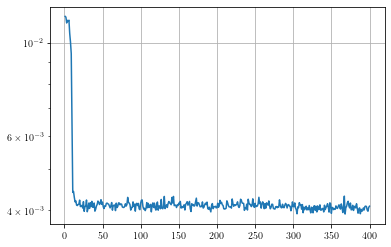

In [14]:
ml_params = {'model_dir': './data/trained_benchmark/',  # folder where the metadata of the training are stored
             'validation_split': 0,
             'batch_size': 256,
             'n_epochs': 400,
             'device': 'cpu',
             'mlp_params': {
                 'data_dim': 15,
                 'layers': [],
                 'nonlin': 'id',
                 'output_nonlin': 'id',
                 'dt': 0.01
                 },
             }

# load the data
train_loader, eval_loader = load_data('./data/benchmark.hdf5', prms['model'],
                                      prms['V'], prms['N'], prms['M'], prms['num_traj'], 
                                      ml_params['batch_size'],
                                      ml_params['validation_split'])
# create the model
model = MLLP(ml_params['mlp_params']).to(ml_params['device'])

criterion = torch.nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.01)
scheduler = MultiStepLR(optimizer, milestones=[300, 350], gamma=0.1)

# train the model
loss = train(model, criterion, optimizer, scheduler, train_loader,
            ml_params['n_epochs'], ml_params['device'],
            alpha_1=[5e-5, 0], alpha_2=[])

# name the model
name = 'model_' + str(prms['model']) + \
        '_V_' + str(int(prms['V']*1e3)).zfill(4) + \
        '_N_' + str(int(prms['N'])) + '_M_' + str(int(prms['M']))
# save the model
#torch.save(model.state_dict(), ml_params['model_dir'] + name)

plt.plot([i for i in range(1, ml_params['n_epochs']+1)], loss)
plt.yscale('log')
plt.grid()

## Performance of the model

In [18]:
# import test data
gname = 'cohVec_model_' + str(prms['model']) 

with h5py.File('./data/benchmark_test.hdf5', 'r') as f:
    data_test = f[gname+'/y'][()]

In [19]:
# calculate the average error
errors = np.zeros(10)
for i in range(10):
    ml_dyn = model.generate_trajectory(v_0=np.array(data_test[i][0]), T=20)    
    errors[i] = calculate_error(results_ml=ml_dyn, results_tebd=data_test[i], T=20, dt=0.01)
print(errors.mean())

0.004511181867194997


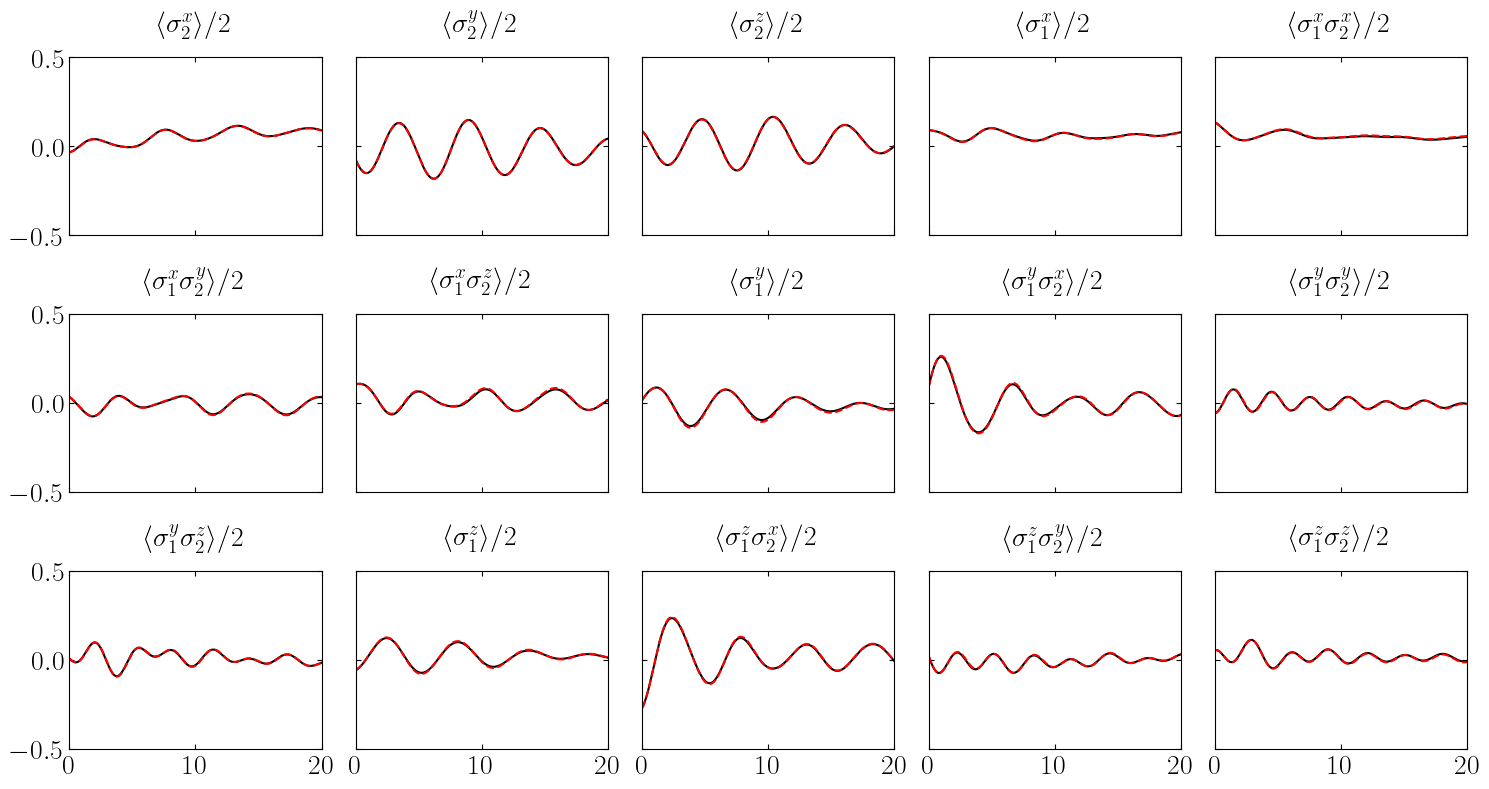

In [22]:
# select the test data to compare with, indx \in [1,10]
indx = 1
# predict dynamics with the model
ml_dyn = model.generate_trajectory(v_0=np.array(data_test[indx][0]), T=20)    
print_comparison(data_test[indx], ml_dyn, 20, dt=0.01, ylim=0.5)

## Full plot

Here we plot the full grid comparing the model for each combination (N,M)

In [85]:
# for each combinations of N and M I calculate the error, averaged over 10 trajectories
N = [3,5,10,20,30,40,50,60,70,80]
M = [3,5,10,20,30,40,50,60,70,80]

errors = []

# import test data
gname = 'cohVec_model_' + str(prms['model']) 

with h5py.File('./data/benchmark_test.hdf5', 'r') as f:
    data_test = f[gname+'/y'][()]

for m in M:
    err = []
    for n in N:
        # name the model
        name = 'model_' + str(prms['model']) + \
            '_V_' + str(int(prms['V']*1e3)).zfill(4) + \
            '_N_' + str(n) + '_M_' + str(m)
        # import the model
        model = MLLP(ml_params['mlp_params']).to(ml_params['device'])
        model.load_state_dict(torch.load(Path('./data/trained_benchmark/' + name)))
        
        # calculate error
        errs = np.zeros(10)
        for i in range(10):
            ml_dyn = model.generate_trajectory(v_0=np.array(data_test[i][0]), T=20)    
            errs[i] = calculate_error(results_ml=ml_dyn, results_tebd=data_test[i], T=20, dt=0.01)
    
        err.append(errs.mean())
    errors.append(err)

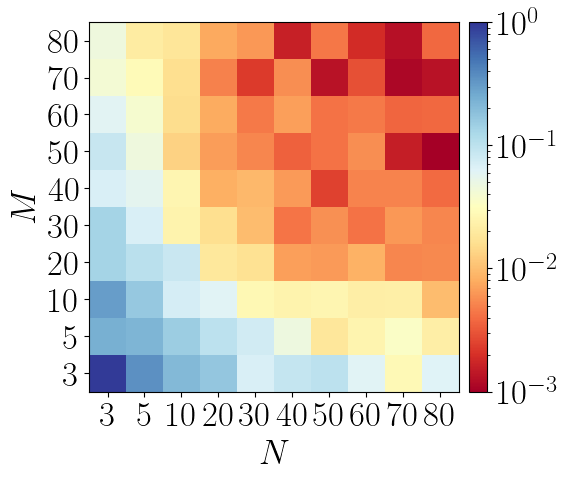

In [87]:
fig, ax = plt.subplots(dpi=100)

im = ax.imshow(errors, origin='lower', cmap='RdYlBu', norm=LogNorm(vmin=0.001, vmax=1))

my_x_ticks = N
my_y_ticks = M
ax.set_xticks([i for i in range(len(my_x_ticks))])
ax.set_xticklabels(['$'+str(i)+'$' for i in my_x_ticks])
ax.set_xlabel(r'$N$', fontsize=25)
ax.set_yticks([i for i in range(len(my_y_ticks))])
ax.set_yticklabels(['$'+str(i)+'$' for i in my_y_ticks])
ax.set_ylabel(r'$M$', fontsize=25)

ax.tick_params(axis='y', labelsize=25)
ax.tick_params(axis='x', labelsize=25)
    
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=25)

plt.show()
#fig.savefig('./plots/benchmark.pdf', dpi=150, bbox_inches='tight')